## Test visualization of calcium imaging data. Created on 11/04/17 by Dan.

**Tasks to be fulfilled: **
1. Load the data and convert the coordinate values into microns.
2. Clean the data if necessary 
3. Perform ICA and cluster the IC coefficients 
4. Display the anatomical distribution of the IC-representing neurons


In [5]:
%matplotlib inline
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('/home/sillycat/Proramming/Python/Image_toolbox/src/')
import src.networks.df_f as df_f
import src.visualization.stat_present as stat_present
import src.visualization.signal_plot as signal_plot
import src.networks.simple_variance as simple_variance
import src.networks.ica_sorting as ica_sorting
import src.networks.clustering as clustering
from sklearn import linear_model 
from sklearn.cluster import KMeans
import glob
import os
import h5py
from collections import deque

In [7]:
n_ic = 3 # number of independent components
n_clusters = 3
frac_trunc = 3 # the fraction of neurons that are used for computing the independent components
global_datapath = '/home/sillycat/Programming/Python/Image_toolbox/data_test/'
local_datafolder = 'FB_resting_15min'

Jul19_2017_A2
(2511, 3)
(5023, 3)
0.595718063878
Jul19_2017_B3
(2550, 3)
(5100, 3)
0.515685470106
Jul26_2017_A1
(1807, 3)
(3614, 3)
0.632208926671
Jul19_2017_A5
(1921, 3)
(3842, 3)
0.778160643053
Jul26_2017_A3
(2098, 3)
(4196, 3)
0.556574568142
Jul19_2017_B1
(2087, 3)
(4174, 3)
0.67867139709
Jul19_2017_A4
(2128, 3)
(4257, 3)
0.490189836309
Jul19_2017_B5
(2310, 3)
(4622, 3)
0.476311519902
Jul19_2017_A3
(1853, 3)
(3707, 3)
0.617664167309


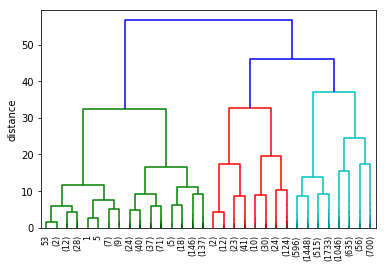

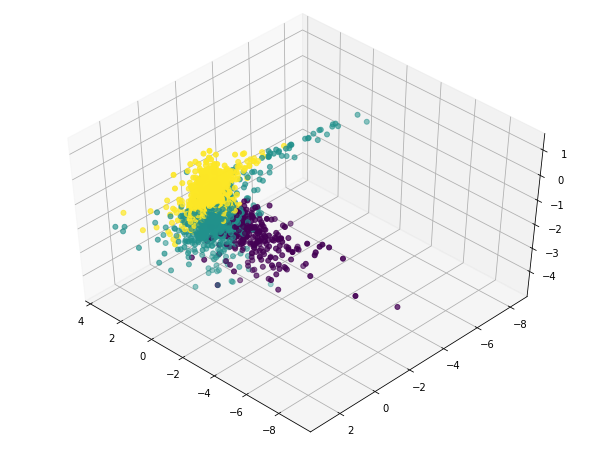

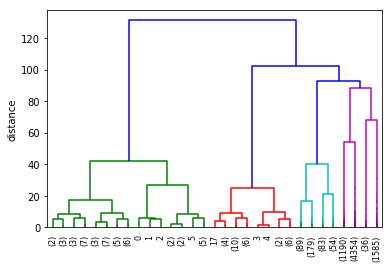

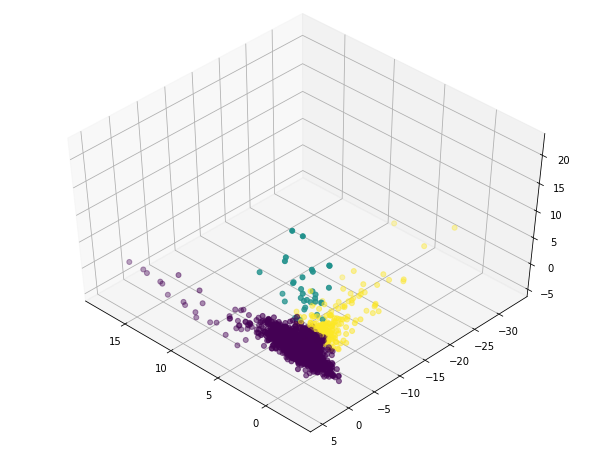

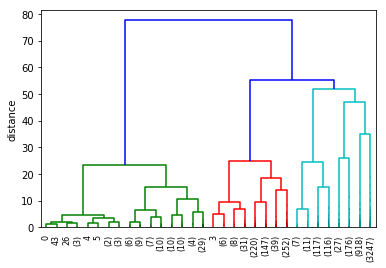

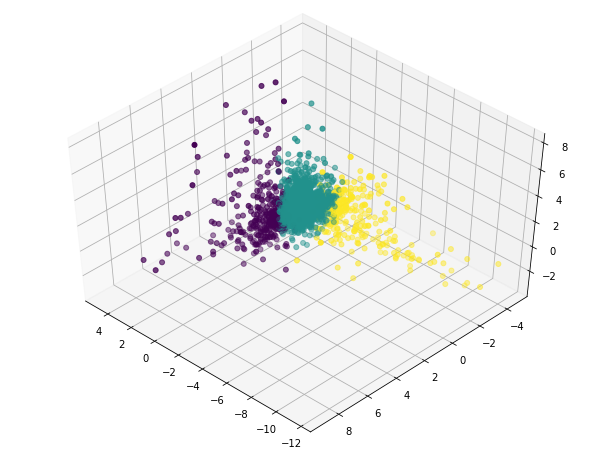

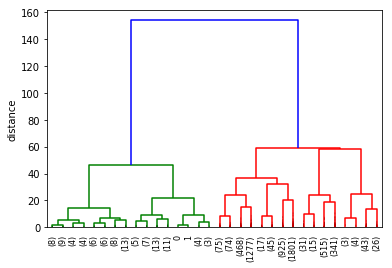

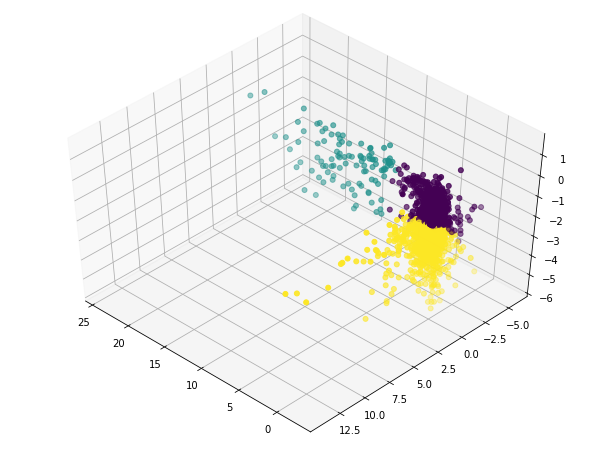

In [ ]:
#  the h5 data sets are all cleaned and the inactive cells are removed.
data_list = glob.glob(global_datapath + local_datafolder + '/*.h5')

for data_fname in data_list:
    basename = '_'.join(os.path.basename(data_fname).split('.')[0].split('_')[:3])
    print(basename)
    fin = h5py.File(data_fname, 'r+')
    brain_coord = np.array(fin['coord'])
    signal = np.array(fin['signal'])
    NT, NC = signal.shape
    n_trunc = int(NC/3)
    dff_ica, a_mix, s_mean = ica_sorting.ica_dff(signal[:,:n_trunc], n_comp = n_ic)
    print(a_mix.shape)
    ic_coeff = ica_sorting.ica_regression(dff_ica, signal[:, n_trunc:]) # fit the rest 
    fin.close()
    print(ic_coeff.shape)
    ico_total = np.r_[a_mix, ic_coeff]
    '''
    Now, let's classify the ic_coeffs
    '''
    figc, R, Z = clustering.dis2cluster(ico_total, p_levels = 4, yield_z = True)
    figc.savefig(global_datapath + local_datafolder + '/'+basename)
    figc.close()
    ind_list_L = clustering.subtree(Z, NC, 'L', True)
    ind_list_R = clustering.subtree(Z, NC, 'R', True)
    
    # question: should I do Kmeans clustering on a_mix or ico_total?
    
    cls_pred = KMeans(n_clusters = 3, random_state = None).fit(ico_total)
    labels = cls_pred.labels_
    
    fig = plt.figure(figsize=(8,6))
    ax = Axes3D(fig, elev = 48, azim = 134)
    ax.scatter(ico_total[:,0], ico_total[:,1], ico_total[:,2], c = labels, s = 25)
    
    coord_cluster = clustering.cluster2anatomy(cl_list= labels, coord= brain_coord)
    
    
